# Gaussian Process Regression in Pytorch

*Thomas Viehmann*, <tv@lernapparat.de>


In [1]:
from matplotlib import pyplot
%matplotlib inline
import IPython
import torch
from torch.autograd import Variable
import numpy
import sys, os
sys.path.append(os.path.join(os.getcwd(),'..'))

In [2]:
import candlegp
import candlegp.training.hmc


Let's have a regression example

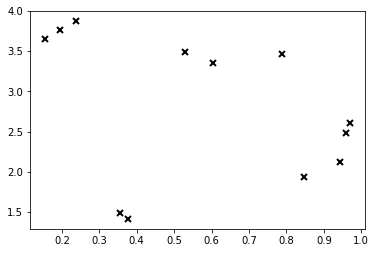

In [3]:
N = 12
X = torch.rand(N,1)
Y = (torch.sin(12*X) + 0.6*torch.cos(25*X) + torch.randn(N,1)*0.1 + 3).squeeze(1)
pyplot.figure()
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


## Creating the model

Not adapted to the data yet...

In [4]:
k = candlegp.kernels.RBF(1, lengthscales=0.3)
m = candlegp.models.GPR(Variable(X), Variable(Y.unsqueeze(1)), kern=k)
m.likelihood.variance.set(0.01)
m

Parameter,Value,Prior,ParamType
kern.variance,[ 1.],None,PositiveParam
kern.lengthscales,[ 0.30000004],None,PositiveParam
likelihood.variance,[ 0.01000001],None,PositiveParam


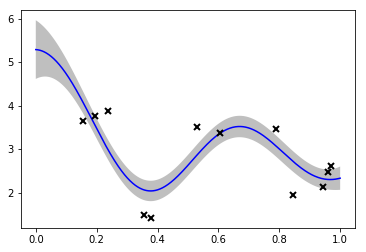

In [6]:
xstar = torch.linspace(0,1,1000)
mu, var = m.predict_y(Variable(xstar.unsqueeze(1)))
cred_size = (var**0.5*2).squeeze(1)

mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


## Maximum-A-Posteriori

One commonly used approach to model selection is to maximize the marginal log likelihood. This is the "gp" equivalent of a maximum-likelihood estimate.

In [7]:
opt = torch.optim.SGD(m.parameters(), lr=1e-2)
for i in range(1000):
    obj = m()
    opt.zero_grad()
    obj.backward()
    opt.step()
    if i%100==0:
        print(i,':',obj.data[0])
    

0 : 218.67135620117188
100 : 33.035560607910156
200 : 32.77554702758789
300 : 32.71620178222656
400 : 32.696815490722656
500 : 32.68959045410156
600 : 32.68660354614258
700 : 32.68537139892578
800 : 32.684898376464844
900 : 32.684688568115234


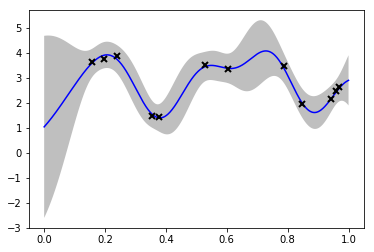

In [8]:
xstar = torch.linspace(0,1,1000)
mu, var = m.predict_y(Variable(xstar.unsqueeze(1)))
cred_size = (var**0.5*2).squeeze(1)

mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


## Hamiltonian Monte Carlo

We can go more Bayesian by putting a prior on the parameters and do Hamiltonian Monte Carlo to draw parameters.

In [9]:
k2 = candlegp.kernels.RBF(1, lengthscales=0.3)
m2 = candlegp.models.GPR(Variable(X), Variable(Y.unsqueeze(1)), kern=k2)
m2.likelihood.variance.set(0.01)

m2.likelihood.variance.prior = candlegp.priors.Gamma(1.0,1.0)
m2.kern.variance.prior = candlegp.priors.Gamma(1.0,1.0)
m2.kern.lengthscales.prior = candlegp.priors.Gamma(1.0,1.0)
#samples = m.sample(500, epsilon=0.2, verbose=1)

In [10]:
res = candlegp.training.hmc.hmc_sample(m2,500,0.2,burn=50, thin=10)

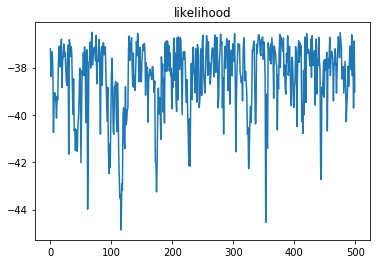

In [11]:
pyplot.plot(res[0]); pyplot.title("likelihood");

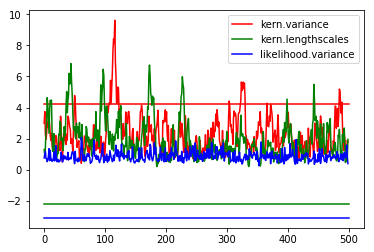

In [12]:
for (n,p0),p,c in zip(m.named_parameters(),res[1:],['r','g','b']):
  pyplot.plot(torch.stack(p).numpy(), c=c, label=n)
  pyplot.plot((0,len(p)),(p0.data[0],p0.data[0]), c=c)
pyplot.legend();

In [13]:
res = candlegp.training.hmc.hmc_sample(m,1000,0.2,burn=50)

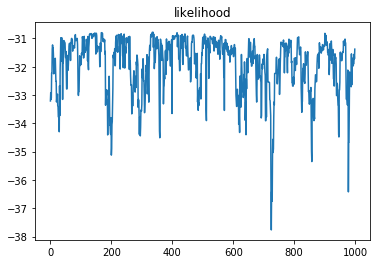

In [14]:
pyplot.plot(res[0]); pyplot.title("likelihood");

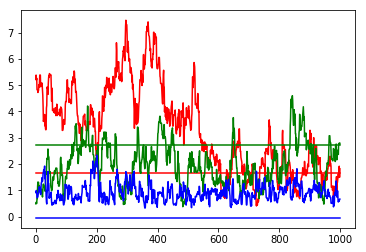

In [15]:
for p0,p,c in zip(m.parameters(),res[1:],['r','g','b']):
  pyplot.plot(torch.stack(p).numpy(), c=c)
  pyplot.plot((0,1000),(p0.data[0],p0.data[0]), c=c)